In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM as tp_lc_functions

In [2]:
def translate_logfeatures_to_nonlognames(namelist,return_dictionary=False):
    '''translate log feature names to non-log paper names'''
    feature_dict={'GroupSpin_dmo_log':'$\lambda$', # spin
        # metallicities, SFR, Nsubs
        'SubhaloGasMetallicity_log':'$Z_{gas}$',
        'SubhaloStarMetallicity_log':'$Z_{star}$',
        'SubhaloSFRinRad_log':'SFR', 'GroupNsubs_log' : '$N_{subs}$',
         # Galaxy Masses         
        'SubhaloBHMass_log':'$M_{BH}$', 'SubhaloBHMass_hs_log':'$M_{BH} / M_{vir}$',
        'SubhaloBHMdot_log':'$\dot{M}_{BH}$','SubhaloBHMdot_hs_log':'$\dot{M}_{BH} / M_{vir}$', 
        'SubhaloMstar_log':'$M_{star}$', 'SubhaloMstar_hs_log':'$M_{star} / M_{vir}$',
        'SubhaloMgas_log':'$M_{gas}$','SubhaloMgas_hs_log':'$M_{gas} / M_{vir}$',
        'SubhaloMHI_log':'$M_{HI}$','SubhaloMHI_hs_log':'$M_{HI} / M_{vir}$',
        'SubhaloMH2_log':'$M_{H2}$','SubhaloMH2_hs_log':'$M_{H2} / M_{vir}$',
         # Velocities         
        'SubhaloVelDisp_log':'$\sigma_V$','SubhaloVelDisp_hs_log':'$\sigma_V/V_{vir}$',
        'SubhaloVmax_log':'$V_{max}$', 'SubhaloVmax_hs_log':'$V_{max} / V_{vir}$',

        # Halo variables
        'Group_M_TopHat200_log':'$M_{vir}$','Group_V_TopHat200_log':'$V_{vir}$',
        'Group_R_TopHat200_log':'$R_{vir}$',
                  # Galaxy Sizes
                  'SubhaloRgas_log':'$R_{gas}$', 'SubhaloRgas_hs_log':'$R_{gas} / R_{vir}$',
                  'SubhaloVmaxRad_log':'$R_{Vmax}$', 'SubhaloVmaxRad_hs_log':'$R_{Vmax} / R_{vir}$',
                  'SubhaloRstar_log': '$R_{star}$', 'SubhaloRstar_hs_log':'$R_{star} / R_{vir}$'}
    if return_dictionary:
        return feature_dict
    elif isinstance(namelist,str):
        print('dysh')

        return feature_dict(namelist)
    else:
        print('tresh')

        return [feature_dict[f] for f in namelist]

In [3]:
df_RF = pd.read_csv('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG_Raw_Max_r_scores_by_add_column_method.csv')
df_SVR = pd.read_csv('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_SVR_Max r scores by add column method.csv')
df_RF_hs = pd.read_csv('TNG-SIM_images/v23a_Disks_RF_FeatRank_0DwMvir/v23a_Disks_TNG_0DwMvir_Max_r_scores_by_add_column_method.csv')
df_SVR_hs = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_Disks_TNG-SIM_0DwMvir_SVR_Max r scores by add column method.csv')
    

In [4]:
df_RF

,feature_number,features,r_sq_score
0,1,SubhaloMH2_log,0.446484
1,2,SubhaloStarMetallicity_log,0.709776
2,3,SubhaloMstar_log,0.811974
3,4,SubhaloVmaxRad_log,0.822093
4,5,SubhaloGasMetallicity_log,0.838548
5,6,SubhaloSFRinRad_log,0.849192
6,7,SubhaloVelDisp_log,0.848177
7,8,SubhaloBHMass_log,0.848448
8,9,GroupSpin_dmo_log,0.853403
9,10,SubhaloVmax_log,0.852367


## Disks Raw ranking

In [5]:
number_features = 5
list_features = []

fdict_RF = translate_logfeatures_to_nonlognames(df_RF.features,return_dictionary=False)
fdict_SVR = translate_logfeatures_to_nonlognames(df_SVR.features,return_dictionary=False)

df_RF.features = df_RF.features.map(dict(zip(df_RF.features, fdict_RF)))
df_SVR.features = df_SVR.features.map(dict(zip(df_SVR.features, fdict_SVR)))

datasets = [df_RF, df_SVR] 

# datasets_names = [str(l) for l in range(1,10)]
datasets_names = ['RF', 'SVR']

all_top_n_feats = []

for i, _dataset in enumerate(datasets):
    all_top_n_feats.extend(list(_dataset.loc[:number_features-1,'features'].values))
    all_top_n_feats = list(set(all_top_n_feats))
    

tresh
tresh


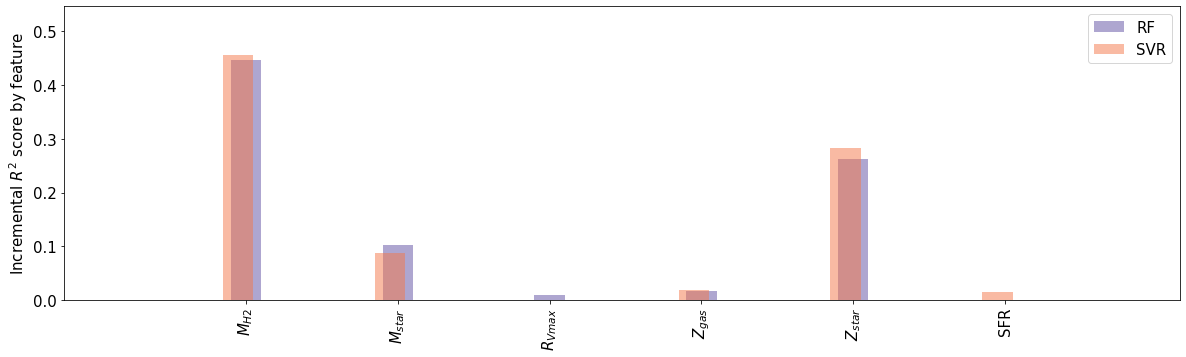

In [9]:
# Plot the feature importances from RF and SVR models for the raw dataset

plt.figure(figsize=(20,6))

# plt.title("TNG-SIM Disks Add-on Feature Importances \n from Random Forests and Support Vector Regressor")

for i, _dataset in enumerate(datasets):
    dataset = _dataset.copy()
    
    dataset.loc[1:,'r_sq_score'] = dataset.loc[:,'r_sq_score'].diff()[1:]

    importances = dataset.loc[:number_features -1, 'r_sq_score']
    importances.index = dataset.loc[:number_features-1,'features']
    
    
    for l in [l for l in all_top_n_feats if l not in importances.index]:
        importances[l] = 0
        
    importances.sort_index(inplace=True)
#     color_list = cm.Spectral_r(30*i+20)
#     color_list = cm.Spectral_r(60*i+200)
    color_list = cm.Spectral_r(200*i)

#     print(color_list)
    plt.bar(np.arange(len(importances))+0.05*(-i), importances, 
        align="center", width=0.2, alpha = 0.5, label = datasets_names[i], 
        color = color_list)
    
    plt.xticks(range(len(list(importances.index))), labels = list(importances.index), rotation=90)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    # Pad margins so that markers don't get clipped by the axes
    plt.margins(0.2)
    plt.ylabel(r'Incremental $R^{2}$ score by feature', size=15)
    plt.legend(loc='upper right', fontsize=15)
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.2)
    
# plt.savefig('TNG-SIM_images/v25_Addon_FeatureImportances_RF_SVR/Disks_FeatImp_Raw_RF_SVR_papernames_notitile.pdf', dpi=500)
    

### Disks 0D ranking

In [10]:
number_features = 5
list_features = []

fdict_RF_hs = translate_logfeatures_to_nonlognames(df_RF_hs.features,return_dictionary=False)
fdict_SVR_hs = translate_logfeatures_to_nonlognames(df_SVR_hs.features,return_dictionary=False)

df_RF_hs.features = df_RF_hs.features.map(dict(zip(df_RF_hs.features, fdict_RF_hs)))
df_SVR_hs.features = df_SVR_hs.features.map(dict(zip(df_SVR_hs.features, fdict_SVR_hs)))

datasets = [df_RF_hs, df_SVR_hs] 

# datasets_names = [str(l) for l in range(1,10)]
datasets_names = ['RF', 'SVR']


all_top_n_feats = []

for i, _dataset in enumerate(datasets):
    all_top_n_feats.extend(list(_dataset.loc[:number_features-1,'features'].values))
    all_top_n_feats = list(set(all_top_n_feats))

tresh
tresh


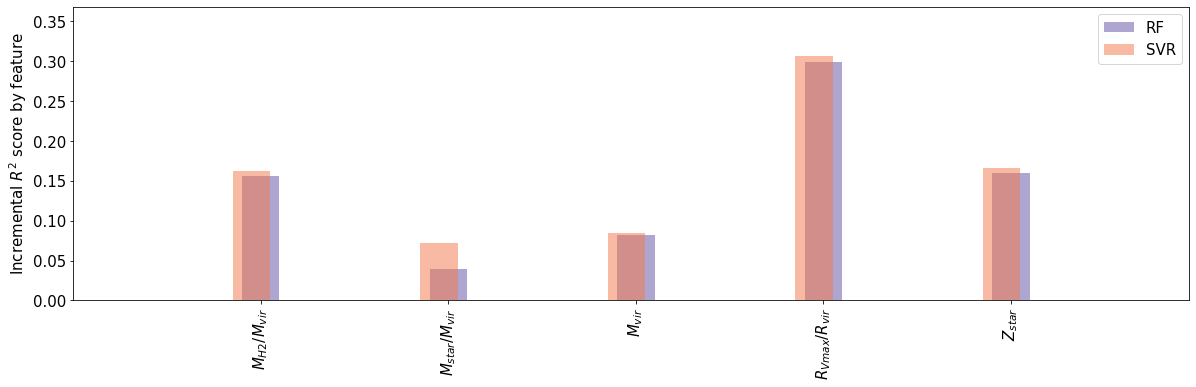

In [13]:
# Plot the feature importances from RF and SVR models for the 0D dataset

plt.figure(figsize=(20,6))

# plt.title("TNG-SIM Disks Add-on Feature Importances from halo-scaled+Mvir dataset \n from Random Forests and Support Vector Regressor")

for i, _dataset in enumerate(datasets):
    dataset = _dataset.copy()
    
    dataset.loc[1:,'r_sq_score'] = dataset.loc[:,'r_sq_score'].diff()[1:]

    importances = dataset.loc[:number_features -1, 'r_sq_score']
    importances.index = dataset.loc[:number_features-1,'features']
    
    
    for l in [l for l in all_top_n_feats if l not in importances.index]:
        importances[l] = 0
        
    importances.sort_index(inplace=True)
#     color_list = cm.Spectral_r(30*i+20)
#     color_list = cm.Spectral_r(60*i+200)
    color_list = cm.Spectral_r(200*i)

#     print(color_list)
    plt.bar(np.arange(len(importances))+0.05*(-i), importances, 
        align="center", width=0.2, alpha = 0.5, label = datasets_names[i], 
        color = color_list)
    
    plt.xticks(range(len(list(importances.index))), labels = list(importances.index), rotation=90)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    # Pad margins so that markers don't get clipped by the axes
    plt.margins(0.2)
    plt.ylabel(r'Incremental $R^{2}$ score by feature', size=15)

    plt.legend(loc='upper right', fontsize=15)
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.2)
    
# plt.savefig('TNG-SIM_images/v25_Addon_FeatureImportances_RF_SVR/Disks_FeatImp_0DMvir_RF_SVR_papernames_notitle.pdf', dpi=500)
    

# All dataset Ranking

## All dataset Raw

In [14]:
df_RF = pd.read_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG_Raw_AllDataset_Max_r_scores_by_add_column_method.csv')
df_SVR = pd.read_csv('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_SVR_Max r scores by add column method.csv')


In [15]:
number_features = 5
list_features = []

fdict_RF = translate_logfeatures_to_nonlognames(df_RF.features,return_dictionary=False)
fdict_SVR = translate_logfeatures_to_nonlognames(df_SVR.features,return_dictionary=False)

df_RF.features = df_RF.features.map(dict(zip(df_RF.features, fdict_RF)))
df_SVR.features = df_SVR.features.map(dict(zip(df_SVR.features, fdict_SVR)))

datasets = [df_RF, df_SVR] 

# datasets_names = [str(l) for l in range(1,10)]
datasets_names = ['RF', 'SVR']

all_top_n_feats = []

for i, _dataset in enumerate(datasets):
    all_top_n_feats.extend(list(_dataset.loc[:number_features-1,'features'].values))
    all_top_n_feats = list(set(all_top_n_feats))
    

tresh
tresh


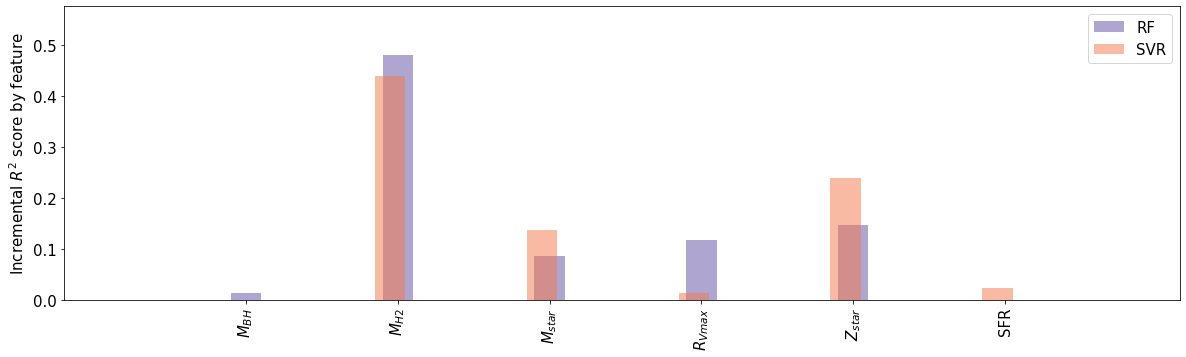

In [18]:
# Plot the feature importances from RF and SVR models for the raw dataset

plt.figure(figsize=(20,6))

# plt.title("TNG-SIM All Dataset Add-on Feature Importances \n from Random Forests and Support Vector Regressor")

for i, _dataset in enumerate(datasets):
    dataset = _dataset.copy()
    
    dataset.loc[1:,'r_sq_score'] = dataset.loc[:,'r_sq_score'].diff()[1:]

    importances = dataset.loc[:number_features -1, 'r_sq_score']
    importances.index = dataset.loc[:number_features-1,'features']
    
    
    for l in [l for l in all_top_n_feats if l not in importances.index]:
        importances[l] = 0
        
    importances.sort_index(inplace=True)
#     color_list = cm.Spectral_r(30*i+20)
#     color_list = cm.Spectral_r(60*i+200)
    color_list = cm.Spectral_r(200*i)

#     print(color_list)
    plt.bar(np.arange(len(importances))+0.05*(-i), importances, 
        align="center", width=0.2, alpha = 0.5, label = datasets_names[i], 
        color = color_list)
    
    plt.xticks(range(len(list(importances.index))), labels = list(importances.index), rotation=90)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    # Pad margins so that markers don't get clipped by the axes
    plt.margins(0.2)
    plt.ylabel(r'Incremental $R^{2}$ score by feature', size=15)
    plt.legend(loc='upper right', fontsize=15)
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.2)
    
# plt.savefig('TNG-SIM_images/v25_Addon_FeatureImportances_RF_SVR/AllDataset_FeatImp_Raw_RF_SVR_papernames_notitle.pdf', dpi=500)
    

## All Dataset 0D

In [19]:
df_RF_hs = pd.read_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG_0D_AllDatasetwMvir_Max_r_scores_by_add_column_method.csv')
df_SVR_hs = pd.read_csv('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0DwMvir_AllDataset_SVR_Max r scores by add column method.csv')
    

In [20]:
number_features = 5
list_features = []

fdict_RF_hs = translate_logfeatures_to_nonlognames(df_RF_hs.features,return_dictionary=False)
fdict_SVR_hs = translate_logfeatures_to_nonlognames(df_SVR_hs.features,return_dictionary=False)

df_RF_hs.features = df_RF_hs.features.map(dict(zip(df_RF_hs.features, fdict_RF_hs)))
df_SVR_hs.features = df_SVR_hs.features.map(dict(zip(df_SVR_hs.features, fdict_SVR_hs)))

datasets = [df_RF_hs, df_SVR_hs] 

# datasets_names = [str(l) for l in range(1,10)]
datasets_names = ['RF', 'SVR']


all_top_n_feats = []

for i, _dataset in enumerate(datasets):
    all_top_n_feats.extend(list(_dataset.loc[:number_features-1,'features'].values))
    all_top_n_feats = list(set(all_top_n_feats))

tresh
tresh


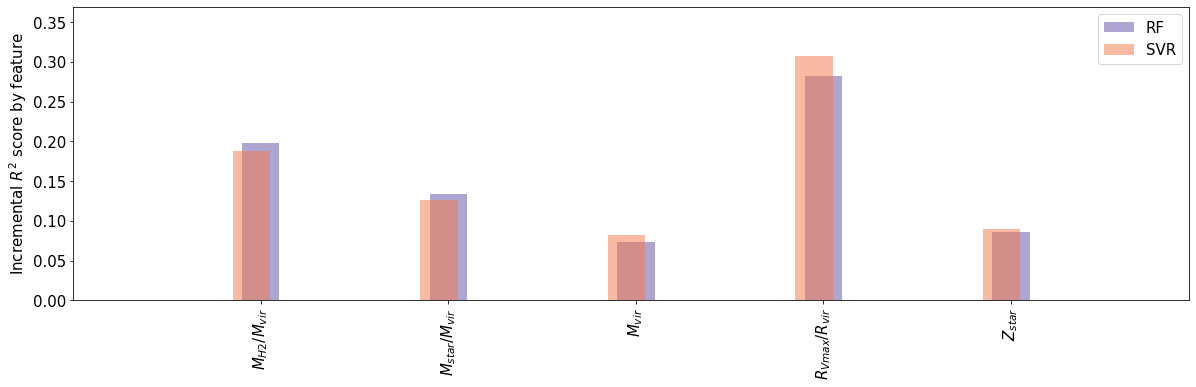

In [22]:
# Plot the feature importances from RF and SVR models for the 0D dataset

plt.figure(figsize=(20,6))

# plt.title("TNG-SIM All Dataset Add-on Feature Importances from halo-scaled dataset (0D+Mvir) \n from Random Forests and Support Vector Regressor")

for i, _dataset in enumerate(datasets):
    dataset = _dataset.copy()
    
    dataset.loc[1:,'r_sq_score'] = dataset.loc[:,'r_sq_score'].diff()[1:]

    importances = dataset.loc[:number_features -1, 'r_sq_score']
    importances.index = dataset.loc[:number_features-1,'features']
    
    
    for l in [l for l in all_top_n_feats if l not in importances.index]:
        importances[l] = 0
        
    importances.sort_index(inplace=True)
#     color_list = cm.Spectral_r(30*i+20)
#     color_list = cm.Spectral_r(60*i+200)
    color_list = cm.Spectral_r(200*i)

#     print(color_list)
    plt.bar(np.arange(len(importances))+0.05*(-i), importances, 
        align="center", width=0.2, alpha = 0.5, label = datasets_names[i], 
        color = color_list)
    
    plt.xticks(range(len(list(importances.index))), labels = list(importances.index), rotation=90)
    # Pad margins so that markers don't get clipped by the axes
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.margins(0.2)
    plt.ylabel(r'Incremental $R^{2}$ score by feature', size=15)

    plt.legend(loc='upper right', fontsize=15)
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.2)
    
# plt.savefig('TNG-SIM_images/v25_Addon_FeatureImportances_RF_SVR/AllDataset_FeatImp_0DwMvir_RF_SVR_papernames_notitle.pdf', dpi=500)
    